In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

In [49]:
df=pd.read_csv("dataset.csv")

In [51]:
df.columns

Index(['Unnamed: 0', 'activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms',
       'id', 'day', 'target_mood'],
      dtype='object')

In [53]:
#sort by data 
df['day'] = pd.to_datetime(df['day'])
df = df.sort_values(by='day')

In [55]:
df['day']

541   2014-03-13
268   2014-03-13
396   2014-03-13
127   2014-03-14
489   2014-03-14
         ...    
809   2014-06-03
810   2014-06-04
811   2014-06-05
812   2014-06-06
813   2014-06-07
Name: day, Length: 1169, dtype: datetime64[ns]

In [57]:
len(df['day'].unique())

86

Mean:              6.9893
Median :       7.0000
25th percentile : 6.6000
75th percentile : 7.5000
IQR: 0.9000


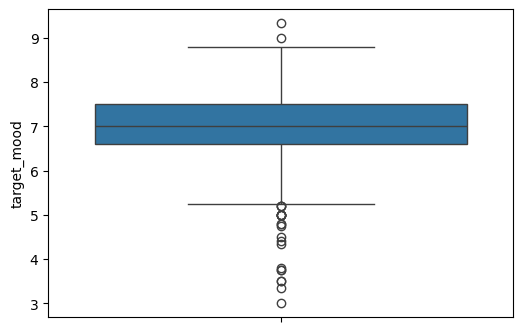

In [61]:

mean_val = df['target_mood'].mean()
median_val = df['target_mood'].median() # 
q1_val = df['target_mood'].quantile(0.25) 
q3_val = df['target_mood'].quantile(0.75)
iqr_val = q3_val - q1_val

print(f"Mean:              {mean_val:.4f}")
print(f"Median :       {median_val:.4f}")
print(f"25th percentile : {q1_val:.4f}")
print(f"75th percentile : {q3_val:.4f}")
print(f"IQR: {iqr_val:.4f}")

plt.figure(figsize=(6, 4))
sns.boxplot(y=df['target_mood']) 
plt.show()

In [8]:
def map_mood_to_class(mood):
    if mood <= 4:
        return 0  # sad
    elif mood <= 6:
        return 1  # neutral
    else:
        return 2  # happy
#create new categrocal target value
df["mood_class"] = df["target_mood"].apply(map_mood_to_class)

df['mood_class'].value_counts(dropna=False).sort_index()

mood_class
0       7
1     116
2    1046
Name: count, dtype: int64

In [9]:
df = df.drop(columns=['Unnamed: 0','id','day', 'target_mood'])

In [10]:
#seperate 80/20
train_df, temp_df = train_test_split(df, test_size=0.2, shuffle=False)

#seperate 20 into 50/50
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (935, 20)
Validation shape: (117, 20)
Test shape: (117, 20)


In [11]:
X_train = train_df.drop(['mood_class'], axis=1).values
y_train = train_df['mood_class'].values

X_val = val_df.drop(['mood_class'], axis=1).values
y_val = val_df['mood_class'].values

X_test = test_df.drop(['mood_class'], axis=1).values
y_test = test_df['mood_class'].values

In [12]:
#one hot encoding for categorical clasess
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [13]:
#validate that time series is correct --> I checked this but now this dindt work because days is remvmove for the model 
"""print(train_df['day'].min())
print(val_df['day'].min())
print(test_df['day'].min())"""

"print(train_df['day'].min())\nprint(val_df['day'].min())\nprint(test_df['day'].min())"

In [14]:
#time steps --> batch size is hyperparameter 
time_steps = 86
batch_size = 16


# use predifined function 
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_train,
    targets=y_train_cat,
    sequence_length=time_steps,
    sampling_rate=1,    # sample rate
    batch_size=batch_size,
    shuffle=True        #  optional 
)

In [15]:

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_val,
    targets=y_val_cat,
    sequence_length=time_steps,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False       
)


In [16]:
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_test,
    targets=y_test_cat,
    sequence_length=time_steps,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False
)


In [17]:
# batch_size, time_steps, num_features

for batch_data, batch_targets in train_dataset.take(1):
    print("Batch data shape:", batch_data.shape)  

Batch data shape: (16, 86, 19)


In [18]:
# define model
model = Sequential()

#shape is based on number of unique timestamps (86) and number of features (19)
model.add(LSTM(units=50, input_shape=(86, 19)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax')) 

#can change the categorical metric from accuracy to some
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,153 (55.29 KB)

 Trainable params: 14,153 (55.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#train the model
history = model.fit(train_dataset, epochs=20, batch_size = batch_size, validation_data=val_dataset)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5313 - loss: 0.9542 - val_accuracy: 0.8750 - val_loss: 0.3792
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9135 - loss: 0.3989 - val_accuracy: 0.9375 - val_loss: 0.2929
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9069 - loss: 0.3495 - val_accuracy: 0.9375 - val_loss: 0.2889
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9033 - loss: 0.3654 - val_accuracy: 0.9375 - val_loss: 0.2914
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9109 - loss: 0.3264 - val_accuracy: 0.9375 - val_loss: 0.2969
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9090 - loss: 0.3419 - val_accuracy: 0.9375 - val_loss: 0.2803
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9094 - loss: 0.3387 - val_accuracy: 0.9062 - val_loss: 0.3143
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8979 - loss: 0.3744 - val_accuracy: 0.9062 - v

In [20]:
# get true lables
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

#change the y_true to match y_pred
y_true = y_test 
y_true = y_test[time_steps - 1:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


              precision    recall  f1-score   support

     Sad (0)       0.00      0.00      0.00         0
 Neutral (1)       0.00      0.00      0.00         4
   Happy (2)       0.88      1.00      0.93        28

    accuracy                           0.88        32
   macro avg       0.29      0.33      0.31        32
weighted avg       0.77      0.88      0.82        32



<Figure size 600x500 with 0 Axes>

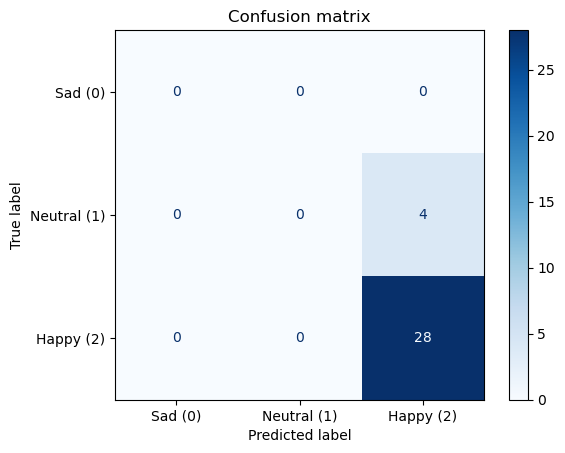

In [21]:
expected_labels = [0, 1, 2]
target_names = ['Sad (0)', 'Neutral (1)', 'Happy (2)']

# classification
print(classification_report(y_true, y_pred,
                          labels=expected_labels,
                          target_names=target_names,
                          zero_division=0))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=expected_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion matrix")
plt.show()

In [22]:
#evaluating of the code
loss, acc = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8542 - loss: 0.4421
Test Loss: 0.3982
Test Accuracy: 0.8750
